In [ ]:
%pip install -q datasets wandb scikit-learn
%pip install -q git+https://github.com/bigscience-workshop/petals@main

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import transformers
import wandb
from datasets import load_dataset, load_metric
from tqdm import tqdm
from torch.optim import AdamW
from torch.utils.data import DataLoader
from transformers import LlamaTokenizer, get_scheduler, set_seed

from petals import DistributedLlamaForSequenceClassification

set_seed(0)

In [ ]:
MODEL_NAME = "enoch/llama-65b-hf"

# Choose a prompt-tuning mode ('ptune' or 'deep_ptune').
# The latter fine-tunes separate prefixes for each transformer block,
# so prompt-tuning will take more time but yield better results.
# See this paper for details of how it works: https://arxiv.org/pdf/2110.07602.pdf
TUNING_MODE = 'ptune'

NUM_PREFIX_TOKENS = 8
DEVICE = 'cuda'
BATCH_SIZE = 32
LR = 1e-2
WEIGHT_DECAY = 0.0
NUM_EPOCHS = 2
SEED = 42
MODEL_MAX_LENGTH = 30

In [ ]:
tokenizer = LlamaTokenizer.from_pretrained(MODEL_NAME)
tokenizer.padding_side = 'right'
tokenizer.model_max_length = MODEL_MAX_LENGTH
tokenizer.pad_token = tokenizer.unk_token
model = DistributedLlamaForSequenceClassification.from_pretrained(
    MODEL_NAME,
    pre_seq_len=NUM_PREFIX_TOKENS,
    tuning_mode=TUNING_MODE
).float().to(DEVICE)
model.config.pad_token_id = tokenizer.pad_token_id

Oct 15 13:36:06.730 [INFO] Make sure you follow the LLaMA's terms of use: https://bit.ly/llama2-license for LLaMA 2, https://bit.ly/llama-license for LLaMA 1
Oct 15 13:36:06.731 [INFO] Using DHT prefix: llama-65b-hf
Some weights of DistributedLlamaForSequenceClassification were not initialized from the model checkpoint at enoch/llama-65b-hf and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import pandas as pd

# Load your custom dataset
custom_dataset = pd.read_csv('train.csv')

columns_to_drop = ['following', 'followers', 'actions', 'is_retweet', 'location']
custom_dataset = custom_dataset.drop(columns=columns_to_drop)

custom_dataset.loc[custom_dataset['Type'] == 'Quality', 'Type'] = 0
custom_dataset.loc[custom_dataset['Type'] == 'Spam', 'Type'] = 1

# Assuming 'Text' and 'labels' are the column names
text_data = custom_dataset['Tweet'].tolist()
labels = custom_dataset['Type'].tolist()


In [ ]:
from transformers import LlamaTokenizer

tokenizer = LlamaTokenizer.from_pretrained('enoch/llama-65b-hf')
tokenizer.pad_token = '[PAD]'
# Tokenize and preprocess the text data
tokenized_data = tokenizer(text_data, padding='max_length', max_length = 30, truncation=True, return_token_type_ids=False)


In [ ]:
import os
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence
from transformers import LlamaTokenizer, AdamW, get_scheduler, set_seed
from tqdm import tqdm

In [ ]:
from torch.nn.utils.rnn import pad_sequence

class CustomDataset(Dataset):
    def __init__(self, tokenized_data, labels):
        self.tokenized_data = tokenized_data
        self.labels = labels

    def __len__(self):
        return len(self.tokenized_data['input_ids'])

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.tokenized_data.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

# Convert tokenized_data to a dictionary of lists
tokenized_data = {
    'input_ids': tokenized_data['input_ids'],
    'attention_mask': tokenized_data['attention_mask']
}

# Split your dataset into training and validation
train_size = int(0.8 * len(tokenized_data['input_ids']))
valid_size = len(tokenized_data['input_ids']) - train_size
train_data, valid_data = random_split(range(len(tokenized_data['input_ids'])), [train_size, valid_size])

# Create data loaders for training and validation with padding
def collate_fn(batch):
    input_ids = pad_sequence([item['input_ids'] for item in batch], batch_first=True)
    labels = torch.stack([item['labels'] for item in batch])

    return {
        'input_ids': input_ids,
        'labels': labels
    }

train_dataloader = DataLoader(
    CustomDataset({key: [val[i] for i in train_data] for key, val in tokenized_data.items()}, [labels[i] for i in train_data]),
    shuffle=True,
    batch_size=BATCH_SIZE,
    collate_fn=collate_fn,
    drop_last=True
)
valid_dataloader = DataLoader(
    CustomDataset({key: [val[i] for i in valid_data] for key, val in tokenized_data.items()}, [labels[i] for i in valid_data]),
    batch_size=BATCH_SIZE,
    collate_fn=collate_fn
)


In [ ]:
for n, p in model.named_parameters():
    if p.requires_grad:
        print(n, p.requires_grad, p.device)

model.prompt_embeddings.weight True cuda:0
score.weight True cuda:0


In [ ]:
optimizer = AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader) * NUM_EPOCHS
)


In [ ]:
total_correct = 0
total_predictions = 0
total_true_positives = 0
total_predicted_positives = 0
# Initialize gradient scaler for mixed-precision training
scaler = torch.cuda.amp.GradScaler()


for batch in tqdm(train_dataloader):
    batch = {k: v.to(DEVICE) for k, v in batch.items()}

    with torch.autocast(device_type=DEVICE, dtype=torch.float16):
        outputs = model(**batch)
    loss = outputs.loss
    scaler.scale(loss).backward()

    scaler.step(optimizer)
    scaler.update()
    lr_scheduler.step()
    optimizer.zero_grad()

    # Calculate accuracy and precision for this batch
    predictions = torch.argmax(outputs.logits, dim=1)
    labels = batch["labels"]
    correct = (predictions == labels).sum().item()
    total_correct += correct
    total_predictions += len(labels)

    # If you want to calculate precision as well:
    true_positives = ((predictions == 1) & (labels == 1)).sum().item()
    predicted_positives = (predictions == 1).sum().item()
    total_true_positives += true_positives
    total_predicted_positives += predicted_positives


# Calculate and print accuracy and precision for the entire training dataset
accuracy = total_correct / total_predictions
precision = total_true_positives / total_predicted_positives if total_predicted_positives > 0 else 0.0
print(f"Train Accuracy: {accuracy:.4f}")
print(f"Train Precision: {precision:.4f}")



100%|██████████| 299/299 [7:10:28<00:00, 86.38s/it]

Train Accuracy: 0.8483
Train Precision: 0.8415


In [ ]:
total_correct = 0
total_predictions = 0
total_true_positives = 0
total_predicted_positives = 0

model.eval()  # Set the model to evaluation mode

with torch.no_grad():
    for batch in valid_dataloader:
        batch = {k: v.to(DEVICE) for k, v in batch.items()}
        outputs = model(**batch)
        predictions = torch.argmax(outputs.logits, dim=1)
        labels = batch["labels"]
        correct = (predictions == labels).sum().item()
        total_correct += correct
        total_predictions += len(labels)

        # If you want to calculate precision as well:
        true_positives = ((predictions == 1) & (labels == 1)).sum().item()
        predicted_positives = (predictions == 1).sum().item()
        total_true_positives += true_positives
        total_predicted_positives += predicted_positives

# Calculate and print accuracy and precision for the entire validation dataset
accuracy = total_correct / total_predictions
precision = total_true_positives / total_predicted_positives if total_predicted_positives > 0 else 0.0
print(f"Validation Accuracy: {accuracy:.4f}")
print(f"Validation Precision: {precision:.4f}")


Validation Accuracy: 0.9160
Validation Precision: 0.9133


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np


In [ ]:
true_labels = []
predicted_labels = []


In [ ]:
# Inside your training loop
for batch in tqdm(train_dataloader):
    # Your training code here

    # Calculate accuracy for this batch
    predictions = torch.argmax(outputs.logits, dim=1)
    correct = (predictions == labels).sum().item()
    total_correct += correct
    total_predictions += len(labels)

    # Append true and predicted labels for this batch
    true_labels.extend(labels.cpu().numpy())
    predicted_labels.extend(predictions.cpu().numpy())


100%|██████████| 299/299 [00:00<00:00, 767.96it/s]


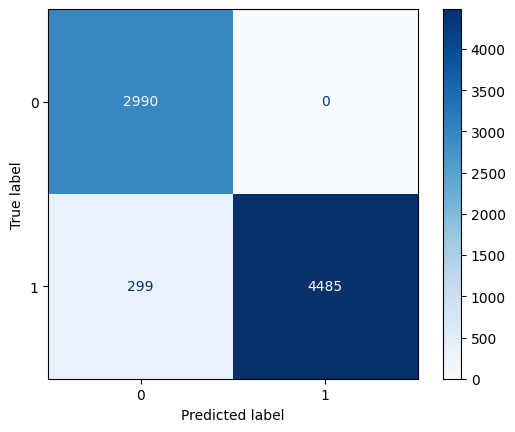

In [ ]:
import matplotlib.pyplot as plt

# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap="Blues")
plt.show()


In [ ]:
from sklearn.metrics import classification_report


In [ ]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Calculate the classification report
class_report = classification_report(true_labels, predicted_labels)

# Display the classification report
print("Classification Report:")
print(class_report)


Classification Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      2990
           1       1.00      0.94      0.97      4784

    accuracy                           0.96      7774
   macro avg       0.95      0.97      0.96      7774
weighted avg       0.97      0.96      0.96      7774

